In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from time import time
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit

In [42]:
pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [161]:
df = pd.read_csv('Churn Modeling.csv')

In [44]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [45]:
df.shape

(10000, 14)

In [46]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

## Continuous Feature

In [47]:
cont_feat = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [48]:
def describe_cont_feature(feature):
    print('\n*** Results for {} ***'.format(feature))
    print(df.groupby('Exited')[feature].describe())

In [49]:
for feat in cont_feat:
    describe_cont_feature(feat)


*** Results for CreditScore ***
         count        mean         std    min    25%    50%    75%    max
Exited                                                                   
0       7963.0  651.853196   95.653837  405.0  585.0  653.0  718.0  850.0
1       2037.0  645.351497  100.321503  350.0  578.0  646.0  716.0  850.0

*** Results for Age ***
         count       mean        std   min   25%   50%   75%   max
Exited                                                            
0       7963.0  37.408389  10.125363  18.0  31.0  36.0  41.0  92.0
1       2037.0  44.837997   9.761562  18.0  38.0  45.0  51.0  84.0

*** Results for Tenure ***
         count      mean       std  min  25%  50%  75%   max
Exited                                                      
0       7963.0  5.033279  2.880658  0.0  3.0  5.0  7.0  10.0
1       2037.0  4.932744  2.936106  0.0  2.0  5.0  8.0  10.0

*** Results for Balance ***
         count          mean           std  min       25%        50%  \
Exite

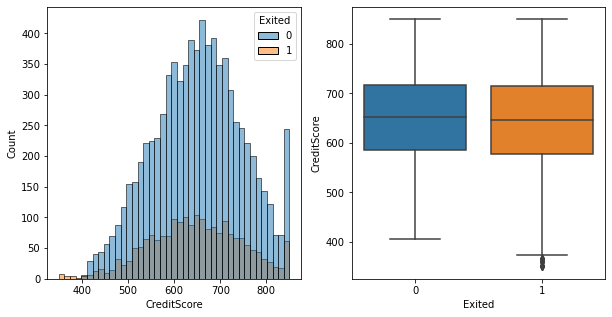

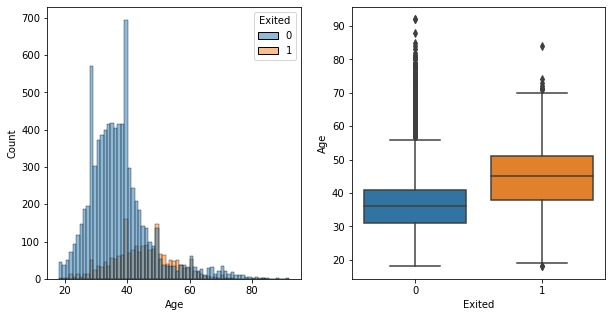

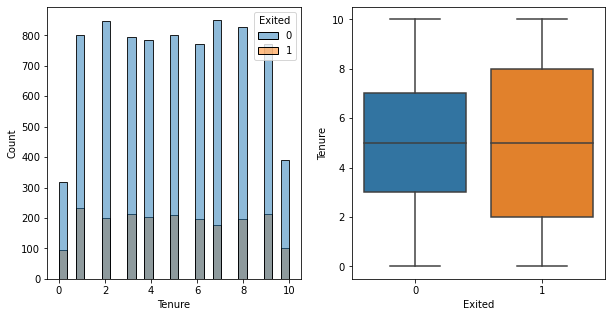

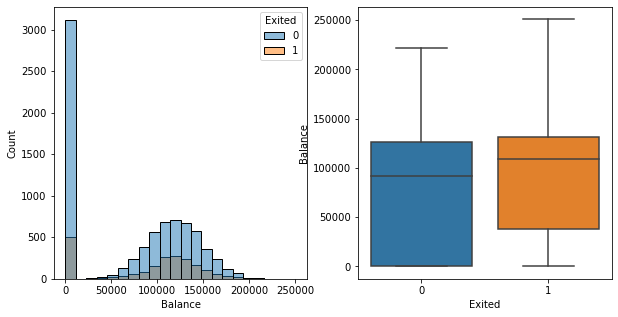

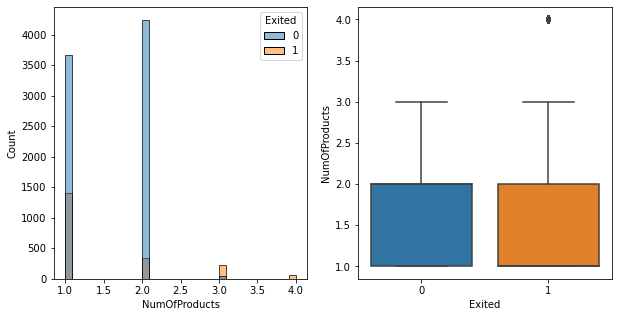

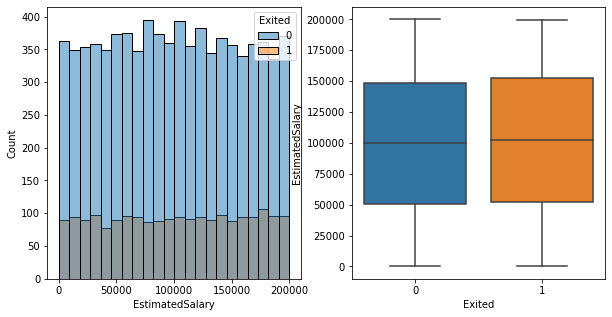

In [50]:
for col in cont_feat:
    f, ax = plt.subplots(1, 2, figsize = (10, 5))
    sns.histplot(data = df, hue = 'Exited', x = col, ax=ax[0])
    sns.boxplot(x='Exited',y=col, data=df, ax=ax[1])
    plt.show()

In [51]:
def detect_outliers(feature):
    outliers = []
    data = df[feature]
    mean = np.mean(data)
    std = np.std(data)
    
    for y in data:
        z_score = (y - mean) / std
        if np.abs(z_score) > 3:
            outliers.append(y)
    print('\n Outliers caps for {}: '.format(feature))
    print('  --95p: {:.1f} / {} values exceed that'.format(data.quantile(.95),
                                                          len([i for i in data if i > data.quantile(.95)])))
    print('  --3sd: {:.1f} / {} values exceed that'.format(mean + 3 * std, len(outliers)))
    print('  --99p: {:.1f} / {} values exceed that'.format(data.quantile(.99), 
                                                          len([i for i in data if i > data.quantile(.99)])))

In [162]:
for feat in cont_feat:
    detect_outliers(feat)


 Outliers caps for CreditScore: 
  --95p: 812.0 / 499 values exceed that
  --3sd: 940.5 / 8 values exceed that
  --99p: 850.0 / 0 values exceed that

 Outliers caps for Age: 
  --95p: 60.0 / 464 values exceed that
  --3sd: 70.4 / 133 values exceed that
  --99p: 72.0 / 85 values exceed that

 Outliers caps for Tenure: 
  --95p: 9.0 / 490 values exceed that
  --3sd: 13.7 / 0 values exceed that
  --99p: 10.0 / 0 values exceed that

 Outliers caps for Balance: 
  --95p: 162711.7 / 500 values exceed that
  --3sd: 263668.7 / 0 values exceed that
  --99p: 185968.0 / 100 values exceed that

 Outliers caps for NumOfProducts: 
  --95p: 2.0 / 326 values exceed that
  --3sd: 3.3 / 60 values exceed that
  --99p: 3.0 / 60 values exceed that

 Outliers caps for EstimatedSalary: 
  --95p: 190155.4 / 500 values exceed that
  --3sd: 272613.1 / 0 values exceed that
  --99p: 198069.7 / 100 values exceed that


### Remove Outiers

In [53]:
df['Age'].clip(upper = df['Age'].quantile(.99), inplace = True)

## Categorical Variables

In [54]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [55]:
cat_feat = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

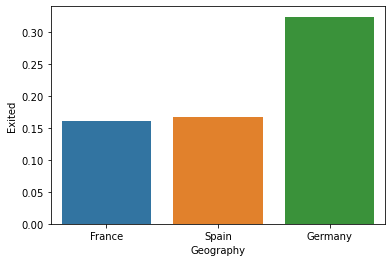

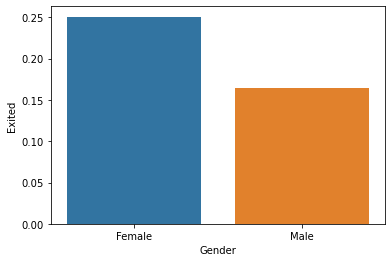

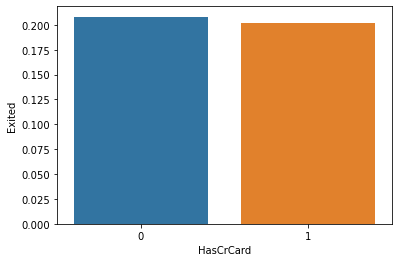

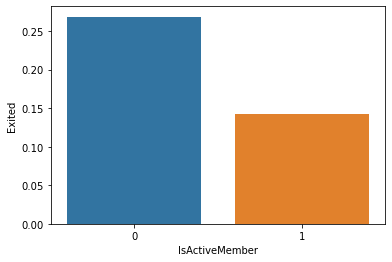

In [56]:
for cols in cat_feat: 
    sns.barplot(x=df[cols], y=df['Exited'], fill=True, alpha=1, ci=None)
    plt.show()

## Transformation

In [57]:
# for col in cat_feat:
#     dummy_cols = pd.get_dummies(df[col], drop_first=True, prefix=col)
#     df = pd.concat([df,dummy_cols],axis=1)
#     df.drop(columns=col, inplace=True)

In [58]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [59]:
df['Log_Age'] = np.log(df['Age'])

In [60]:
df_final = df.drop(['Age'], axis=1)

In [61]:
df_final.head()

,CreditScore,Geography,Gender,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Log_Age
0,619,France,Female,2,0.00,1,1,1,101348.88,1,3.737670
1,608,Spain,Female,1,83807.86,1,0,1,112542.58,0,3.713572
2,502,France,Female,8,159660.80,3,1,0,113931.57,1,3.737670
3,699,France,Female,1,0.00,2,0,0,93826.63,0,3.663562
4,850,Spain,Female,2,125510.82,1,1,1,79084.10,0,3.761200


## Train Val Test Split

In [62]:
y = df_final['Exited'].copy()
X = df_final.drop(['Exited'], axis=1)

In [63]:
#split dataset in training, validation and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state =42)

In [64]:
X_train.head()

,CreditScore,Geography,Gender,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Log_Age
9761,807,Germany,Female,1,72948.58,2,1,1,17355.36,4.094345
3159,834,France,Male,4,131254.81,1,1,0,20199.30,3.135494
1489,609,France,Female,8,141675.23,1,0,1,175664.25,3.663562
2987,676,Germany,Female,1,108348.66,1,0,0,60231.74,3.258097
812,516,Spain,Female,3,0.00,2,1,1,58685.59,3.496508


In [65]:
X_train.shape, y_train.shape

((6000, 10), (6000,))

In [66]:
y_train.value_counts()

0    4773
1    1227
Name: Exited, dtype: int64

In [67]:
for dataset in [y_train, y_val, y_test]:
    print(round(len(dataset) / len(y), 2))

0.6
0.2
0.2


### Mean Encoding

In [68]:
cat_feat

['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

In [69]:
y = 'Exited'
X_train = X_train.join(y_train)
for col in cat_feat:
    target_mean = X_train.groupby(col)[y].mean()
    X_val[col + '_enc'] = X_val[col].map(target_mean)
    X_test[col + '_enc'] = X_test[col].map(target_mean)
    
    #global target mean
    global_mean = X_train[y].mean()
    
    #mean encode title_raw with KFlod regularization
    skf = KFold(n_splits = 7, shuffle = True, random_state = 100)
    for train_ind, val_ind in skf.split(X_train):
        X_tr, X_v = X_train.iloc[train_ind].copy(), X_train.iloc[val_ind].copy()
        means = X_v[col].map(X_tr.groupby(col)[y].mean())
        X_train.loc[X_train.index[val_ind], col+'_enc'] = means
    #Fill title_raw_enc with target global mean
    X_train[col+'_enc'].fillna(global_mean, inplace = True)
    X_val[col+'_enc'].fillna(global_mean, inplace = True)
    X_test[col+'_enc'].fillna(global_mean, inplace = True)

In [70]:
#Drop col from X_train, X_val and X_test
for col in cat_feat:
    X_train.drop([col], axis = 1, inplace = True)
    X_val.drop([col], axis = 1, inplace = True)
    X_test.drop([col], axis = 1, inplace = True)

In [71]:
#Drop Survived from X_train
X_train.drop([y], axis = 1, inplace = True)

In [72]:
X_train.head()

,CreditScore,Tenure,Balance,NumOfProducts,EstimatedSalary,Log_Age,Geography_enc,Gender_enc,HasCrCard_enc,IsActiveMember_enc
9761,807,1,72948.58,2,17355.36,4.094345,0.326661,0.252276,0.199945,0.140543
3159,834,4,131254.81,1,20199.30,3.135494,0.161872,0.166903,0.199945,0.268163
1489,609,8,141675.23,1,175664.25,3.663562,0.167056,0.259678,0.225764,0.147158
2987,676,1,108348.66,1,60231.74,3.258097,0.332543,0.259678,0.225764,0.271923
812,516,3,0.00,2,58685.59,3.496508,0.168210,0.253846,0.202549,0.144141


### Scaling

In [73]:
scaler = MinMaxScaler()

In [74]:
X_train = scaler.fit_transform(X_train)

In [75]:
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [76]:
X_train[:2]

array([[0.914     , 0.1       , 0.29074984, 0.33333333, 0.08637799,
        0.8684828 , 0.93498256, 0.92159923, 0.04661242, 0.03006993],
       [0.968     , 0.4       , 0.52313993, 0.        , 0.10060618,
        0.17681848, 0.03437817, 0.01739827, 0.04659557, 0.9446287 ]])

## Smote

In [77]:
sm = SMOTE(random_state = 100)

In [78]:
X_train, y_train = sm.fit_resample(X_train, y_train)

In [79]:
df.shape

(10000, 12)

In [80]:
pd.DataFrame(X_train).shape

(9546, 10)

## Training

In [81]:
def evaluate_model(name, model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    auc_roc = round(roc_auc_score(labels, pred), 3)
    precision = round(precision_score(labels, pred), 3)
    recall = round(recall_score(labels, pred), 3)
    print('{} -- \tAUC_ROC: {} / Precision: {} / Recall: {} / Latency: {}ms'.format(name,
                                                                                     auc_roc,
                                                                                     precision,
                                                                                     recall,
                                                                                     round((end - start)*1000, 1)))
    return auc_roc, precision, recall
    

### Logistic Regression

In [133]:
scores = []

In [83]:
params = {
    'C': [100, 10, 1.0, 0.1, 0.01]
}

In [84]:
LR = LogisticRegression(max_iter=10000)
grid_LR = GridSearchCV(estimator=LR, param_grid=params, n_jobs=-1, cv=10, scoring='roc_auc')
grid_LR.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01]}, scoring='roc_auc')

In [134]:
train_auc_roc, train_precision, train_recall = evaluate_model('LR', grid_LR, X_train, y_train)

LR -- 	AUC_ROC: 0.712 / Precision: 0.709 / Recall: 0.719 / Latency: 1.0ms


In [135]:
val_auc_roc, val_precision, val_recall = evaluate_model('LR', grid_LR, X_val, y_val)

LR -- 	AUC_ROC: 0.697 / Precision: 0.346 / Recall: 0.708 / Latency: 1.0ms


In [136]:
test_auc_roc, test_precision, test_recall = evaluate_model('LR', grid_LR, X_test, y_test)

LR -- 	AUC_ROC: 0.718 / Precision: 0.402 / Recall: 0.735 / Latency: 0.0ms


In [137]:
model_name = 'Logistic Regression'

scores.append({
    'Model': model_name,
    'Train AUC ROC': train_auc_roc,
    'Val AUC ROC': val_auc_roc,
    'Test AUC ROC Score': test_auc_roc,
    'Test Precision': test_precision,
    'Test Recall': test_recall
})

### SVM

In [89]:
from sklearn import svm

In [90]:
#Create a svm Classifier
svm = svm.SVC(gamma = 'auto', probability=True)

#Train the model using the training sets
svm.fit(X_train, y_train)

SVC(gamma='auto', probability=True)

In [91]:
evaluate_model('SVM', svm, X_test, y_test)

SVM -- 	AUC_ROC: 0.733 / Precision: 0.429 / Recall: 0.733 / Latency: 1219.3ms


(0.733, 0.429, 0.733)

In [138]:
train_auc_roc, train_precision, train_recall = evaluate_model('svm', svm, X_train, y_train)

svm -- 	AUC_ROC: 0.733 / Precision: 0.739 / Recall: 0.721 / Latency: 5929.1ms


In [139]:
val_auc_roc, val_precision, val_recall = evaluate_model('svm', svm, X_val, y_val)

svm -- 	AUC_ROC: 0.699 / Precision: 0.361 / Recall: 0.682 / Latency: 1215.0ms


In [140]:
test_auc_roc, test_precision, test_recall = evaluate_model('svm', svm, X_test, y_test)

svm -- 	AUC_ROC: 0.733 / Precision: 0.429 / Recall: 0.733 / Latency: 1232.0ms


In [141]:
model_name = 'SVM'

scores.append({
    'Model': model_name,
    'Train AUC ROC': train_auc_roc,
    'Val AUC ROC': val_auc_roc,
    'Test AUC ROC Score': test_auc_roc,
    'Test Precision': test_precision,
    'Test Recall': test_recall
})

### Decision Tree

In [96]:
from sklearn.tree import DecisionTreeClassifier

In [97]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [98]:
# DT = DecisionTreeClassifier()

# # Train Decision Tree Classifer
# DT = clf.fit(X_train,y_train)

In [99]:
DT = DecisionTreeClassifier()
grid_DT = GridSearchCV(estimator=DT, param_grid=params, n_jobs=-1, cv=10, scoring='roc_auc')
grid_DT.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='roc_auc')

In [142]:
train_auc_roc, train_precision, train_recall = evaluate_model('DT', grid_DT, X_train, y_train)

DT -- 	AUC_ROC: 0.88 / Precision: 0.897 / Recall: 0.858 / Latency: 2.0ms


In [143]:
val_auc_roc, val_precision, val_recall = evaluate_model('DT', grid_DT, X_val, y_val)

DT -- 	AUC_ROC: 0.712 / Precision: 0.432 / Recall: 0.613 / Latency: 1.0ms


In [144]:
test_auc_roc, test_precision, test_recall = evaluate_model('DT', grid_DT, X_test, y_test)

DT -- 	AUC_ROC: 0.734 / Precision: 0.491 / Recall: 0.653 / Latency: 0.0ms


In [145]:
model_name = 'DT'

scores.append({
    'Model': model_name,
    'Train AUC ROC': train_auc_roc,
    'Val AUC ROC': val_auc_roc,
    'Test AUC ROC Score': test_auc_roc,
    'Test Precision': test_precision,
    'Test Recall': test_recall
})

### Random Forest

In [104]:
# xgb_model = XGBClassifier(random_state=100, use_label_encoder=False, n_jobs=-1)

# xgb_model.fit(X_train, y_train)

In [105]:
params = {
    'n_estimators': [2**i for i in range(3, 10)],
    'max_depth': [2, 4, 8, 16, 32, 64, None],
}

In [106]:
RF = RandomForestClassifier()
grid_RF = GridSearchCV(RF, params, cv = 10, scoring = 'roc_auc', n_jobs = -1)
grid_RF.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 8, 16, 32, 64, None],
                         'n_estimators': [8, 16, 32, 64, 128, 256, 512]},
             scoring='roc_auc')

In [146]:
train_auc_roc, train_precision, train_recall = evaluate_model('RF', grid_RF, X_train, y_train)

RF -- 	AUC_ROC: 1.0 / Precision: 1.0 / Recall: 1.0 / Latency: 626.0ms


In [147]:
val_auc_roc, val_precision, val_recall = evaluate_model('RF', grid_RF, X_val, y_val)

RF -- 	AUC_ROC: 0.756 / Precision: 0.421 / Recall: 0.755 / Latency: 169.0ms


In [148]:
test_auc_roc, test_precision, test_recall = evaluate_model('RF', grid_RF, X_test, y_test)

RF -- 	AUC_ROC: 0.774 / Precision: 0.481 / Recall: 0.779 / Latency: 170.0ms


In [149]:
model_name = 'RF'

scores.append({
    'Model': model_name,
    'Train AUC ROC': train_auc_roc,
    'Val AUC ROC': val_auc_roc,
    'Test AUC ROC Score': test_auc_roc,
    'Test Precision': test_precision,
    'Test Recall': test_recall
})

## XgBoost

In [111]:
params = {
    'n_estimators': [2**i for i in range(3, 10)],
    'learning_rate': np.arange(0.01, 0.1, 0.01),
    'max_depth': np.arange(1, 10, 1),
    'subsample': np.arange(0, 1.1, 0.1),
    'min_child_weight': [1, 2, 3, 4, 5, 10, 50, 100],
    'reg_alpha': [1, 2, 3, 4, 5, 10, 50, 100],
    'reg_lambda':  [1, 2, 3, 4, 5, 10, 50, 100],
    'colsample_bytree':  np.arange(0, 1.1, 0.1),
    'colsample_bylevel':  np.arange(0, 1.1, 0.1),
}

In [112]:
xgb = XGBClassifier(objective = 'binary:logistic')

In [113]:
random_xgb = RandomizedSearchCV(xgb, params, cv = 5, scoring = 'roc_auc',
                                 n_iter = 500, random_state = 10, return_train_score = False, n_jobs = -1)
random_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                        'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                  

In [150]:
train_auc_roc, train_precision, train_recall = evaluate_model('XGB', random_xgb, X_train, y_train)

XGB -- 	AUC_ROC: 0.945 / Precision: 0.968 / Recall: 0.921 / Latency: 34.0ms


In [151]:
val_auc_roc, val_precision, val_recall = evaluate_model('XGB', random_xgb, X_val, y_val)

XGB -- 	AUC_ROC: 0.603 / Precision: 0.229 / Recall: 0.982 / Latency: 11.0ms


In [152]:
test_auc_roc, test_precision, test_recall = evaluate_model('XGB', random_xgb, X_test, y_test)

XGB -- 	AUC_ROC: 0.594 / Precision: 0.254 / Recall: 0.953 / Latency: 9.0ms


In [153]:
model_name = 'XGB'

scores.append({
    'Model': model_name,
    'Train AUC ROC': train_auc_roc,
    'Val AUC ROC': val_auc_roc,
    'Test AUC ROC Score': test_auc_roc,
    'Test Precision': test_precision,
    'Test Recall': test_recall
})

In [154]:
pd.DataFrame(scores)

,Model,Train AUC ROC,Val AUC ROC,Test AUC ROC Score,Test Precision,Test Recall
0,Logistic Regression,0.712,0.697,0.718,0.402,0.735
1,SVM,0.733,0.699,0.733,0.429,0.733
2,DT,0.880,0.712,0.734,0.491,0.653
3,RF,1.000,0.756,0.774,0.481,0.779
4,XGB,0.945,0.603,0.594,0.254,0.953


In [155]:
pd.DataFrame(scores)

,Model,Train AUC ROC,Val AUC ROC,Test AUC ROC Score,Test Precision,Test Recall
0,Logistic Regression,0.712,0.697,0.718,0.402,0.735
1,SVM,0.733,0.699,0.733,0.429,0.733
2,DT,0.880,0.712,0.734,0.491,0.653
3,RF,1.000,0.756,0.774,0.481,0.779
4,XGB,0.945,0.603,0.594,0.254,0.953


In [157]:
def cal_f1_score(precision, recall):
    return round(2 * (precision * recall)/(precision + recall), 3)

results = pd.DataFrame(scores)
results['Test F1 Score'] = cal_f1_score(results['Test Precision'], results['Test Recall'])

In [158]:
results

,Model,Train AUC ROC,Val AUC ROC,Test AUC ROC Score,Test Precision,Test Recall,Test F1 Score
0,Logistic Regression,0.712,0.697,0.718,0.402,0.735,0.520
1,SVM,0.733,0.699,0.733,0.429,0.733,0.541
2,DT,0.880,0.712,0.734,0.491,0.653,0.561
3,RF,1.000,0.756,0.774,0.481,0.779,0.595
4,XGB,0.945,0.603,0.594,0.254,0.953,0.401
